In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR250_10': ('chr1', 170530445, 170533865)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_250_10", 
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR250/HJR250_10/HJR250_10_merged.fastq.gz", 
    working_dir =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [3]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)


Computing sequence bias


100%|██████████| 102485/102485 [01:56<00:00, 880.64it/s] 


88209 reads aligned. 14276 reads unaligned


In [17]:
locus = "HJR250_10"


In [4]:
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250/HJR250_10_ddda_101024.pkl", "wb") as f:
    pickle.dump(ddda_data, f)

In [5]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250/HJR250_10_ddda_101024.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [9]:
min_num=10000
undel_read_ids=np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)

In [10]:
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = undel_read_ids
)

100%|██████████| 10000/10000 [00:01<00:00, 8858.07it/s]
10000it [00:00, 1184597.40it/s]


In [11]:
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

In [14]:
selected_read_inds = undel_read_inds
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.zeros(len(undel_read_inds))
selection_dict = {"HJR250_10":selected_reads}

In [15]:
# Calculate nucleosome footprints for individual reads
footprints_dict_nuc = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [50], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_nuc = np.squeeze(np.array([i for i in footprints_dict_nuc[locus].values()]))
fp_nuc = -np.log10(fp_nuc)

Computing footprints for HJR250_10


100%|██████████| 2520/2520 [00:05<00:00, 427.99it/s]


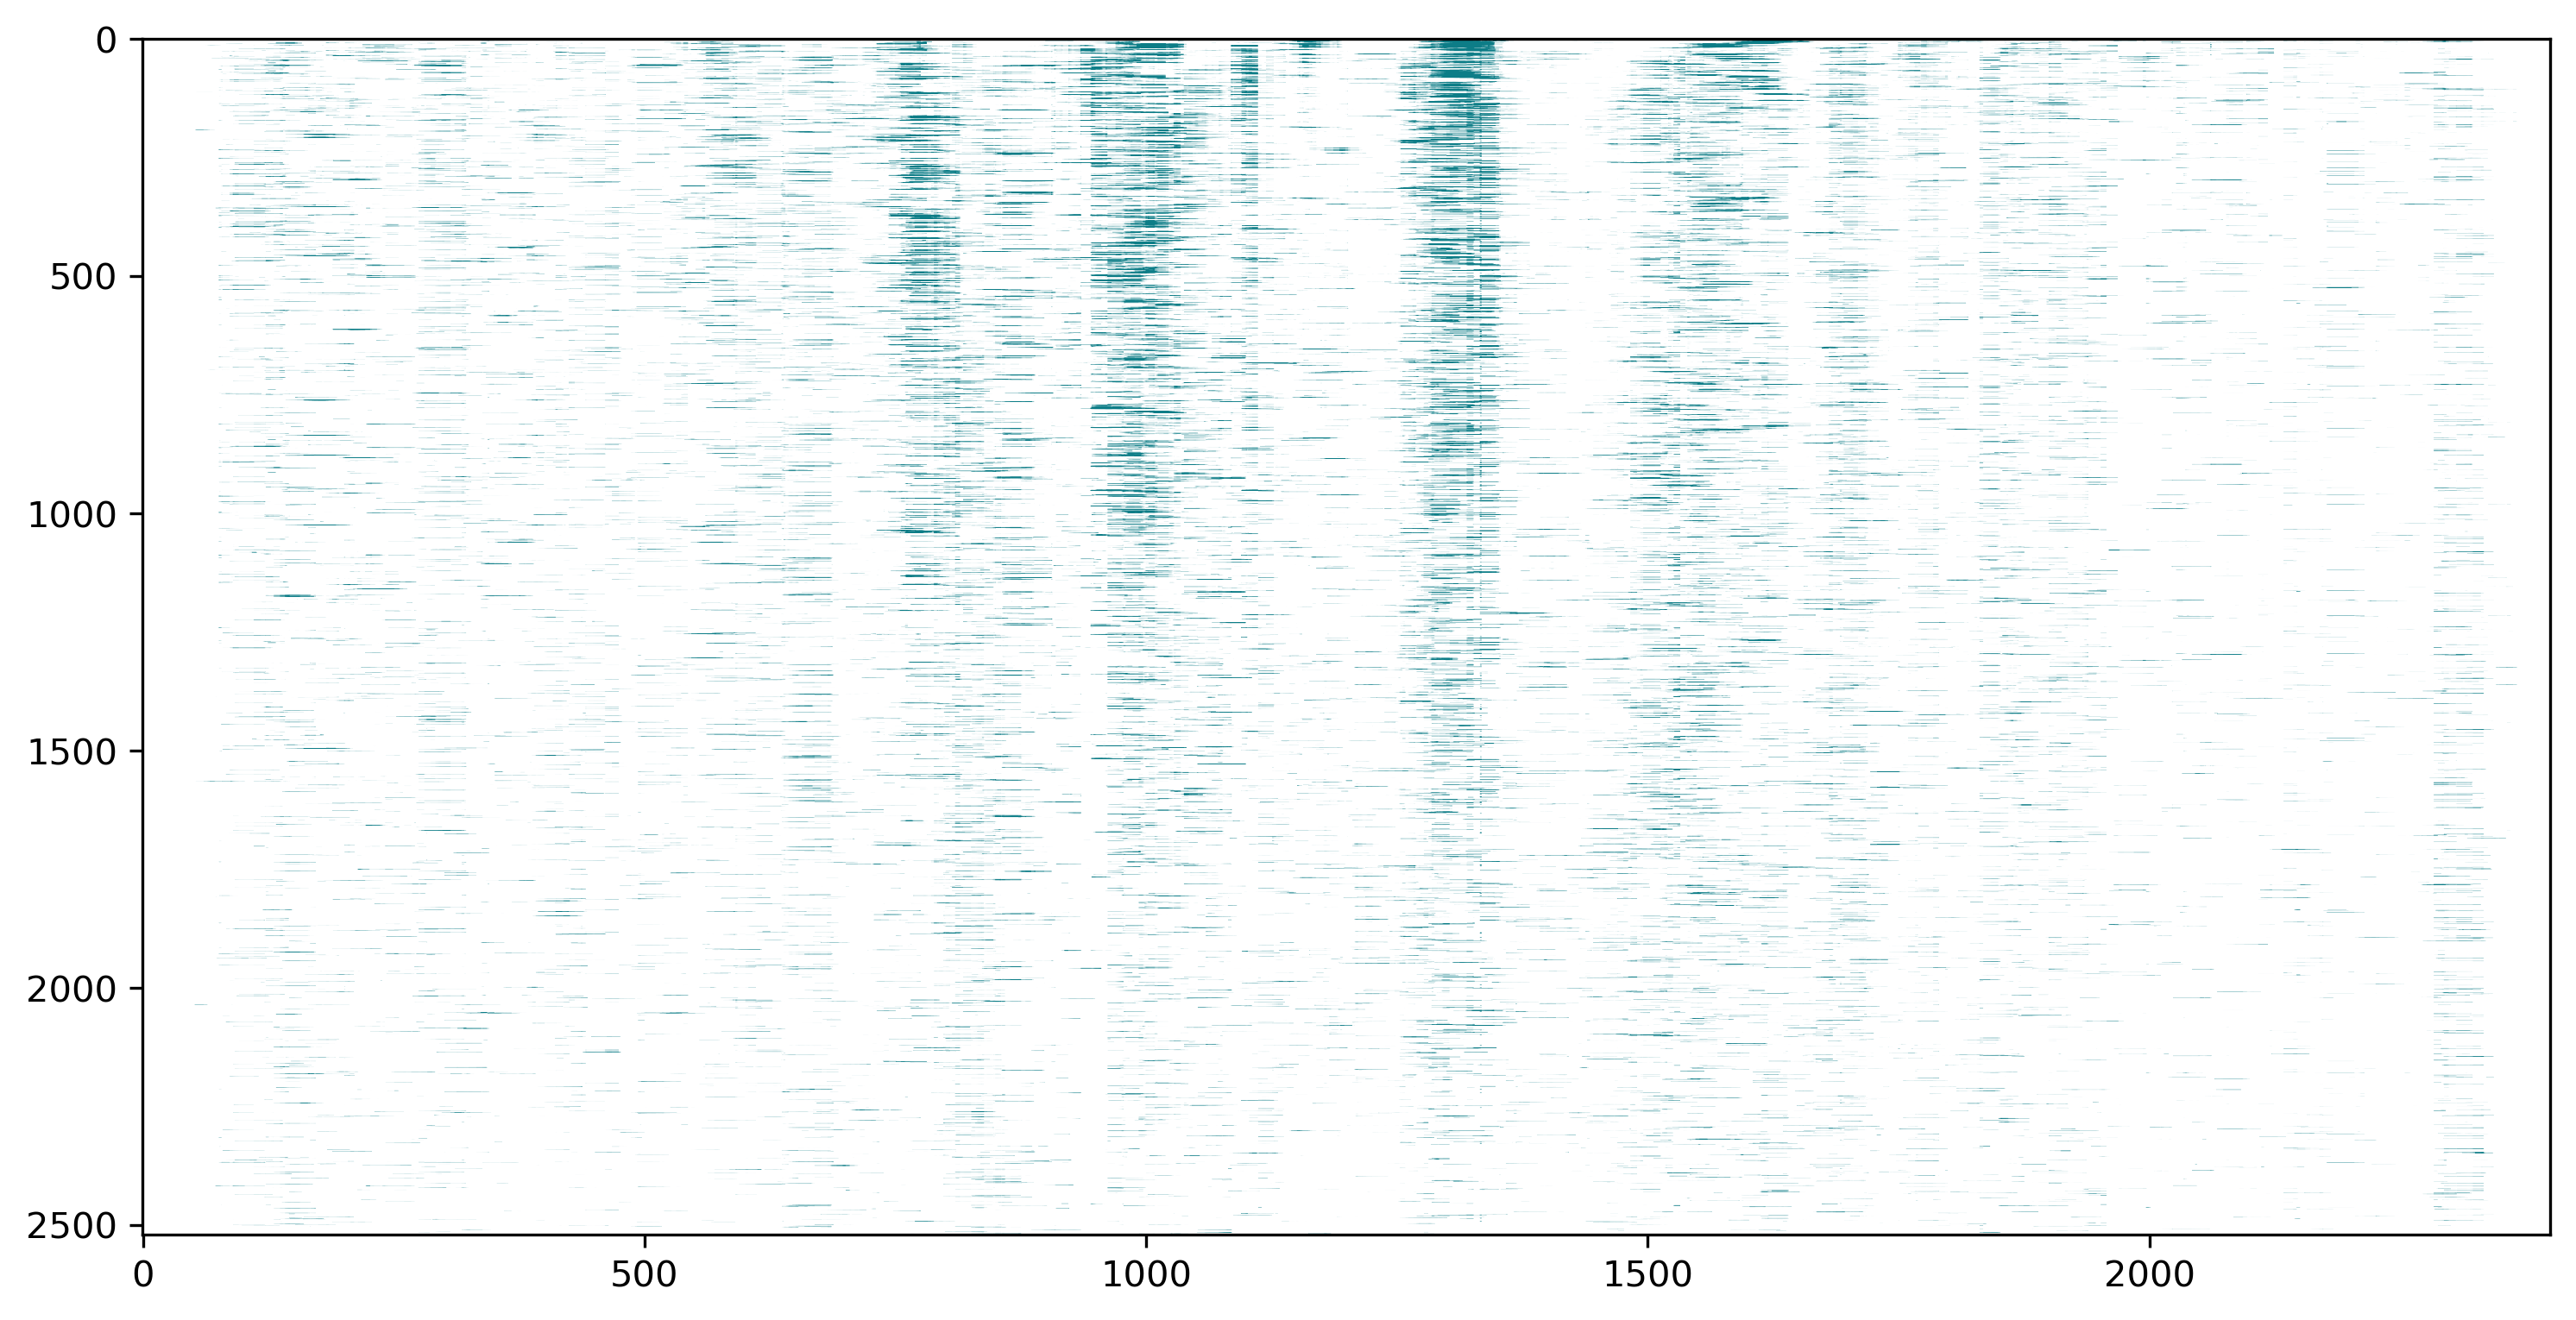

In [19]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(500, 2900)
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.1, cmap=dark_green_cmap )

plt.show()

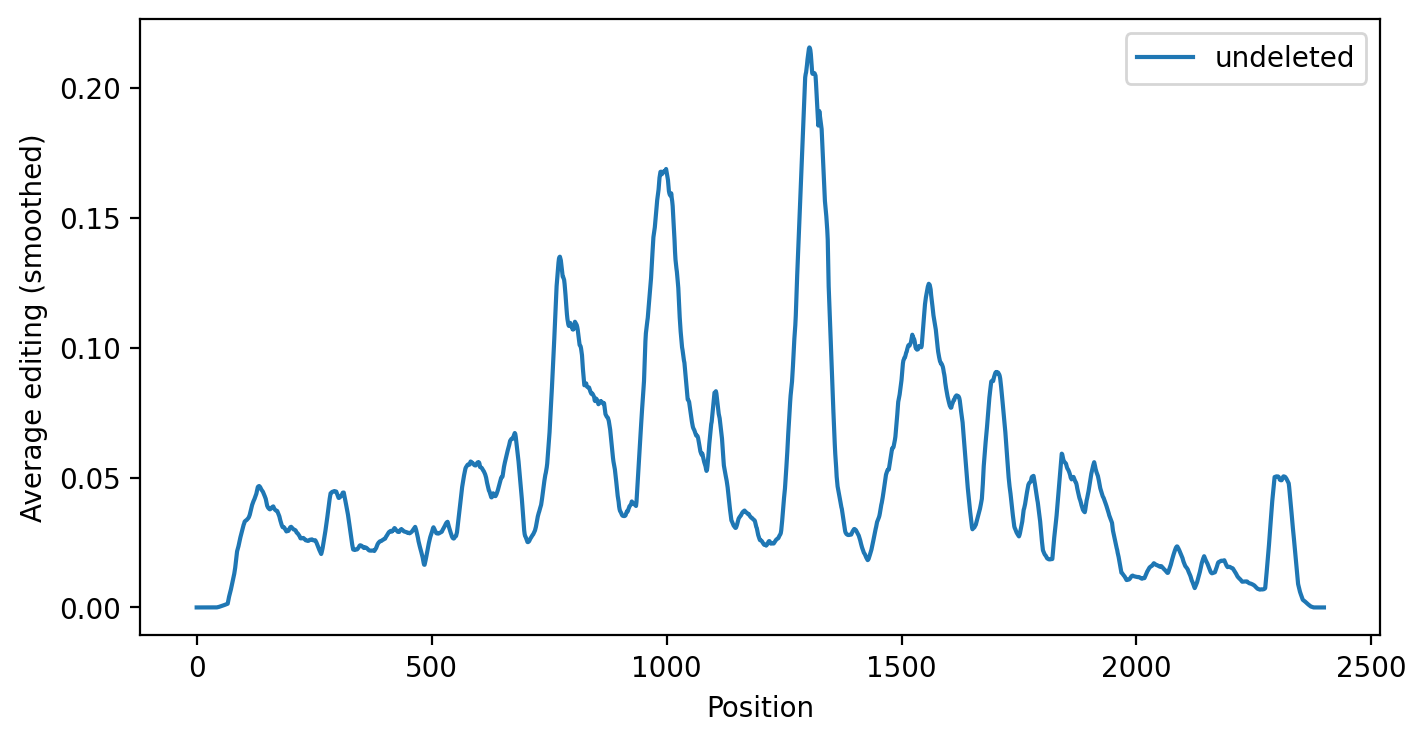

In [20]:
# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted_fp_nuc = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis = 0)
track_undeleted_fp_nuc = np.convolve(
    track_undeleted_fp_nuc, 
    np.ones(smooth_radius), 
    mode="same") / smooth_radius

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_undeleted_fp_nuc)), track_undeleted_fp_nuc, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

In [21]:
# Calculate nucleosome footprints for individual reads
footprints_dict_TF = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [25], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_TF = np.squeeze(np.array([i for i in footprints_dict_TF[locus].values()]))
fp_TF = -np.log10(fp_TF)

Computing footprints for HJR250_10


100%|██████████| 2520/2520 [00:04<00:00, 528.44it/s]


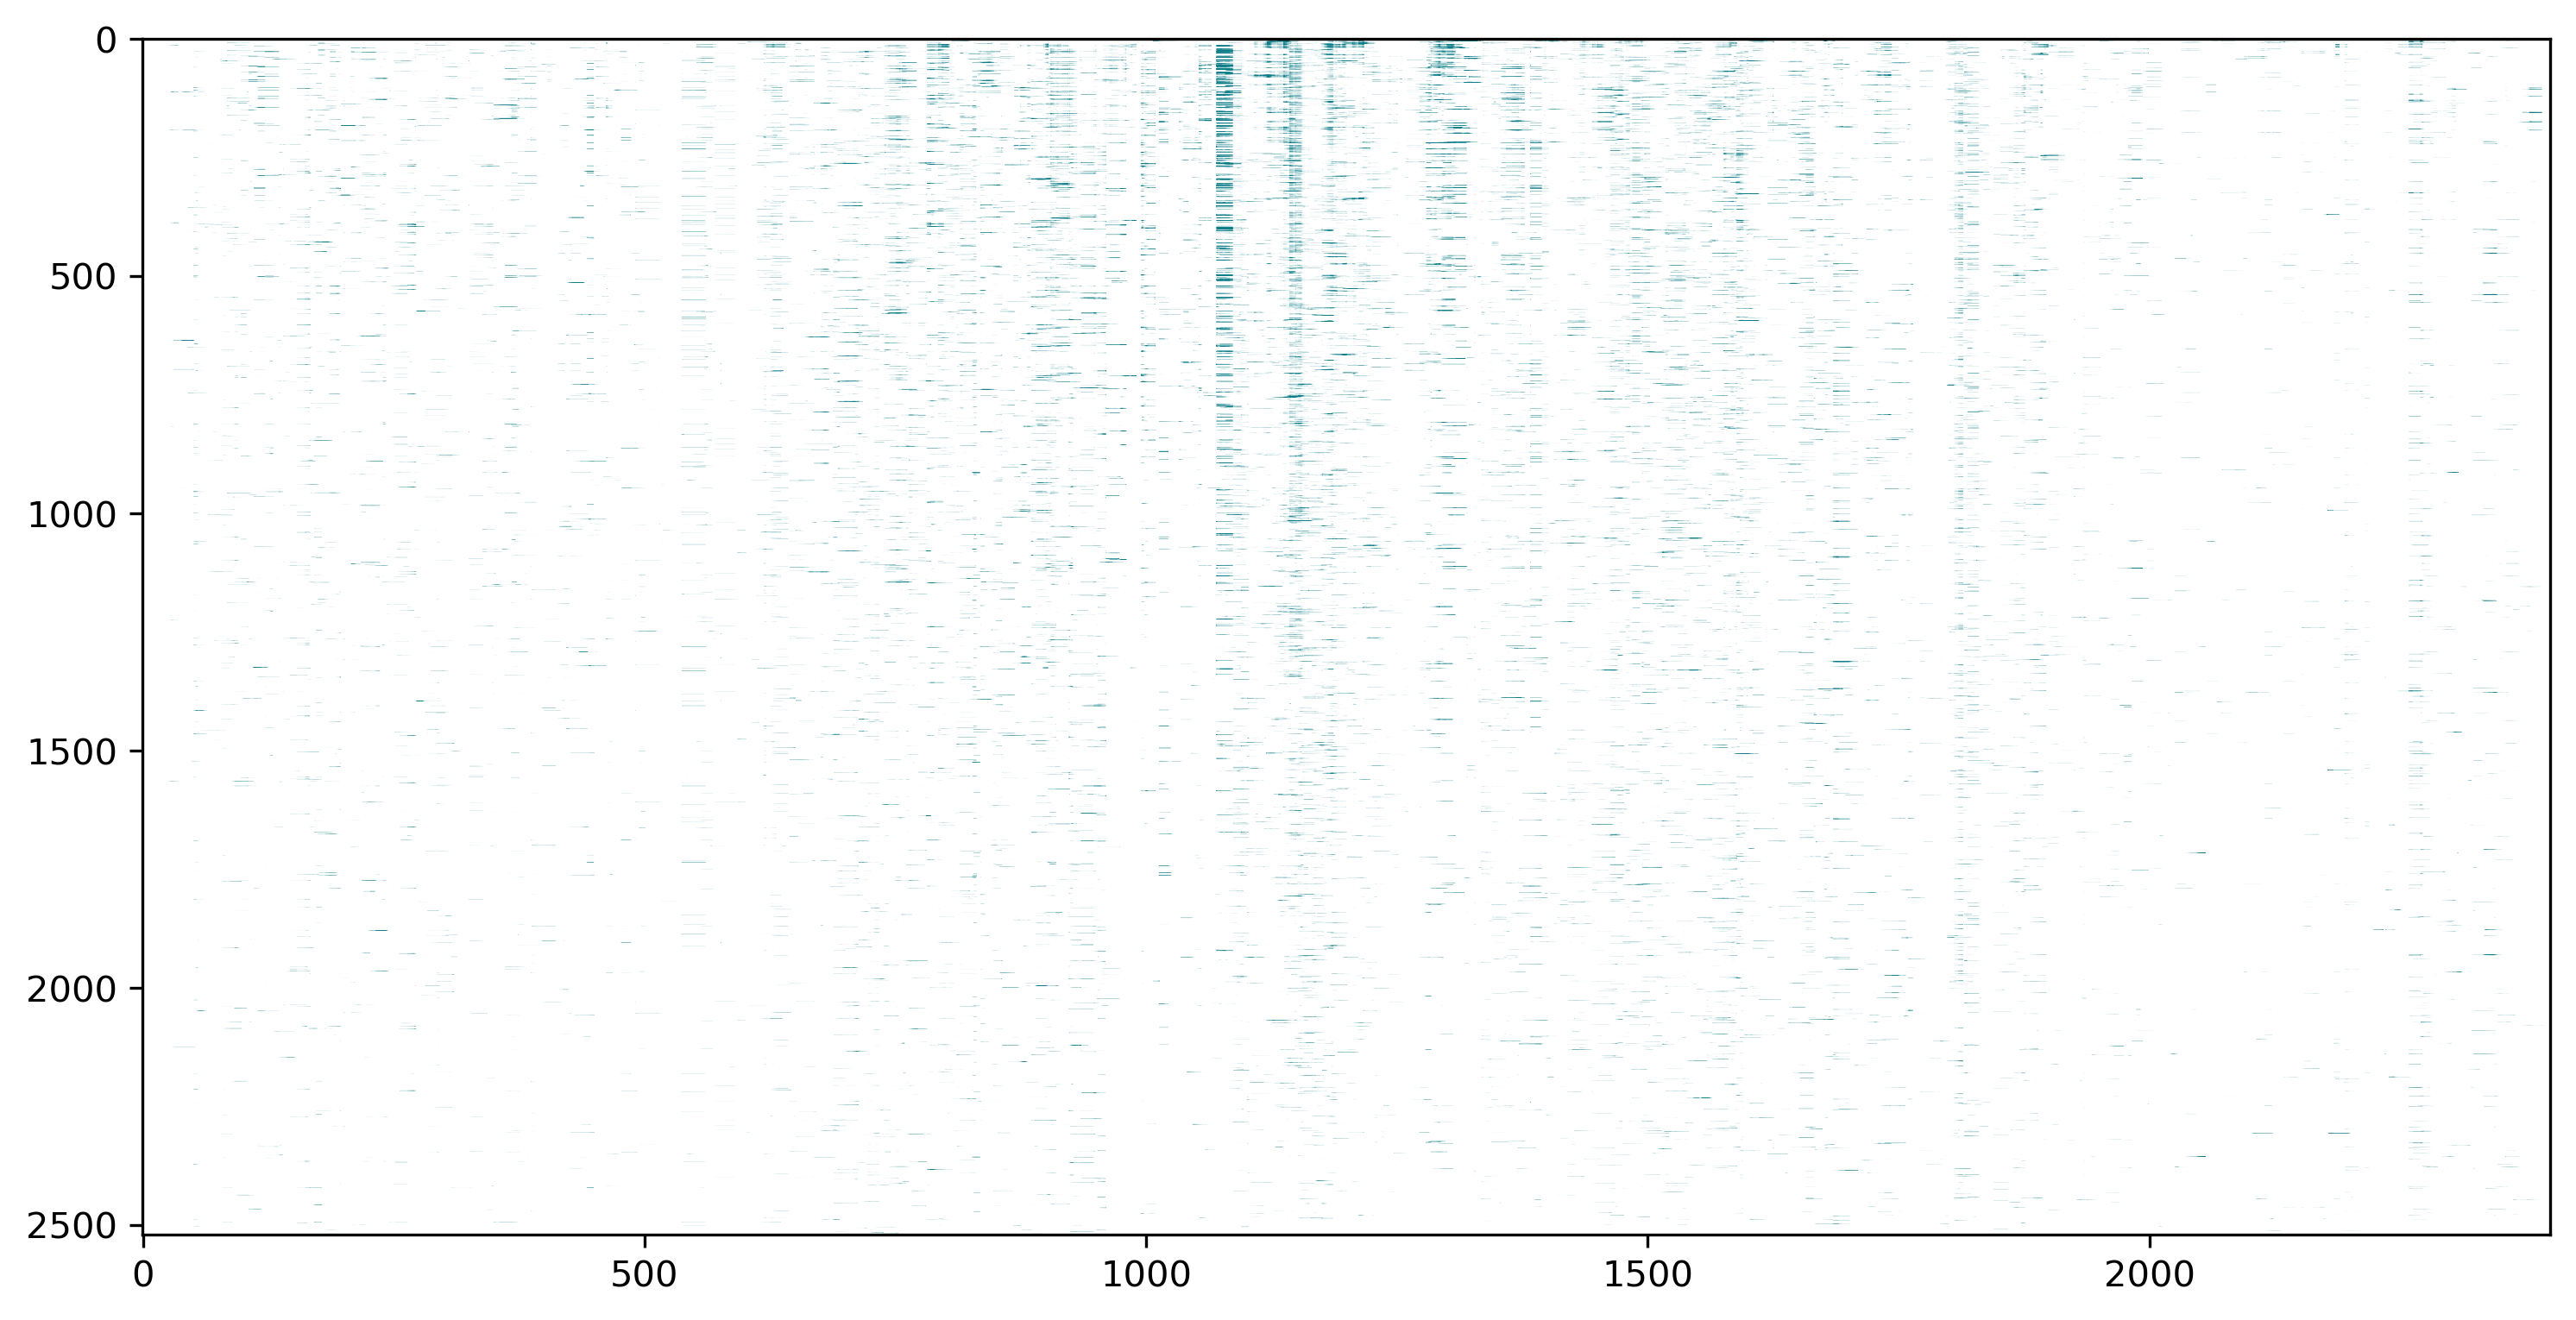

In [22]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(500, 2900)
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax.imshow(fp_TF[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.1, cmap=dark_green_cmap)

plt.show()

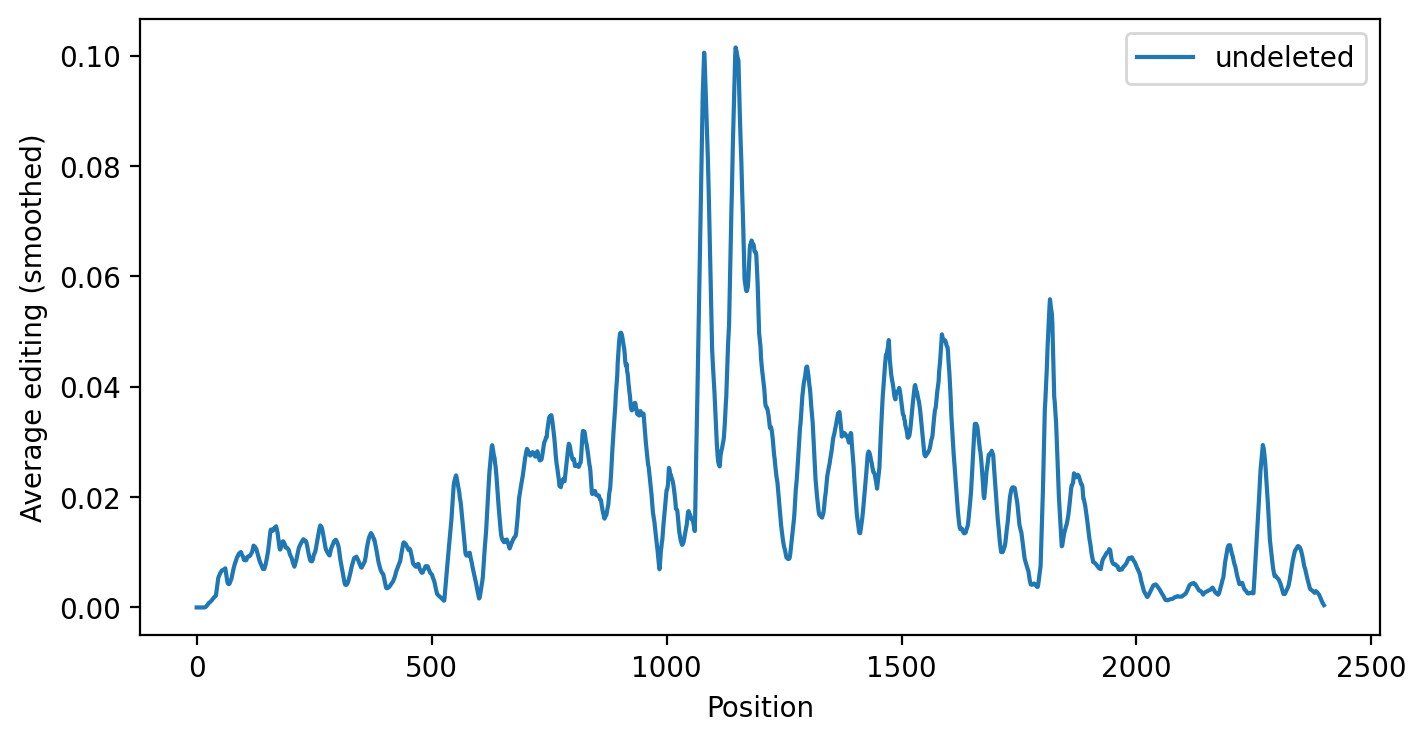

In [23]:
# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted_fp_TF = np.mean(fp_TF[selected_del_flags == 0, :][:, plot_range], axis = 0)
track_undeleted_fp_TF = np.convolve(
    track_undeleted_fp_TF, 
    np.ones(smooth_radius), 
    mode="same") / smooth_radius

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_undeleted_fp_TF)), track_undeleted_fp_TF, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.show()

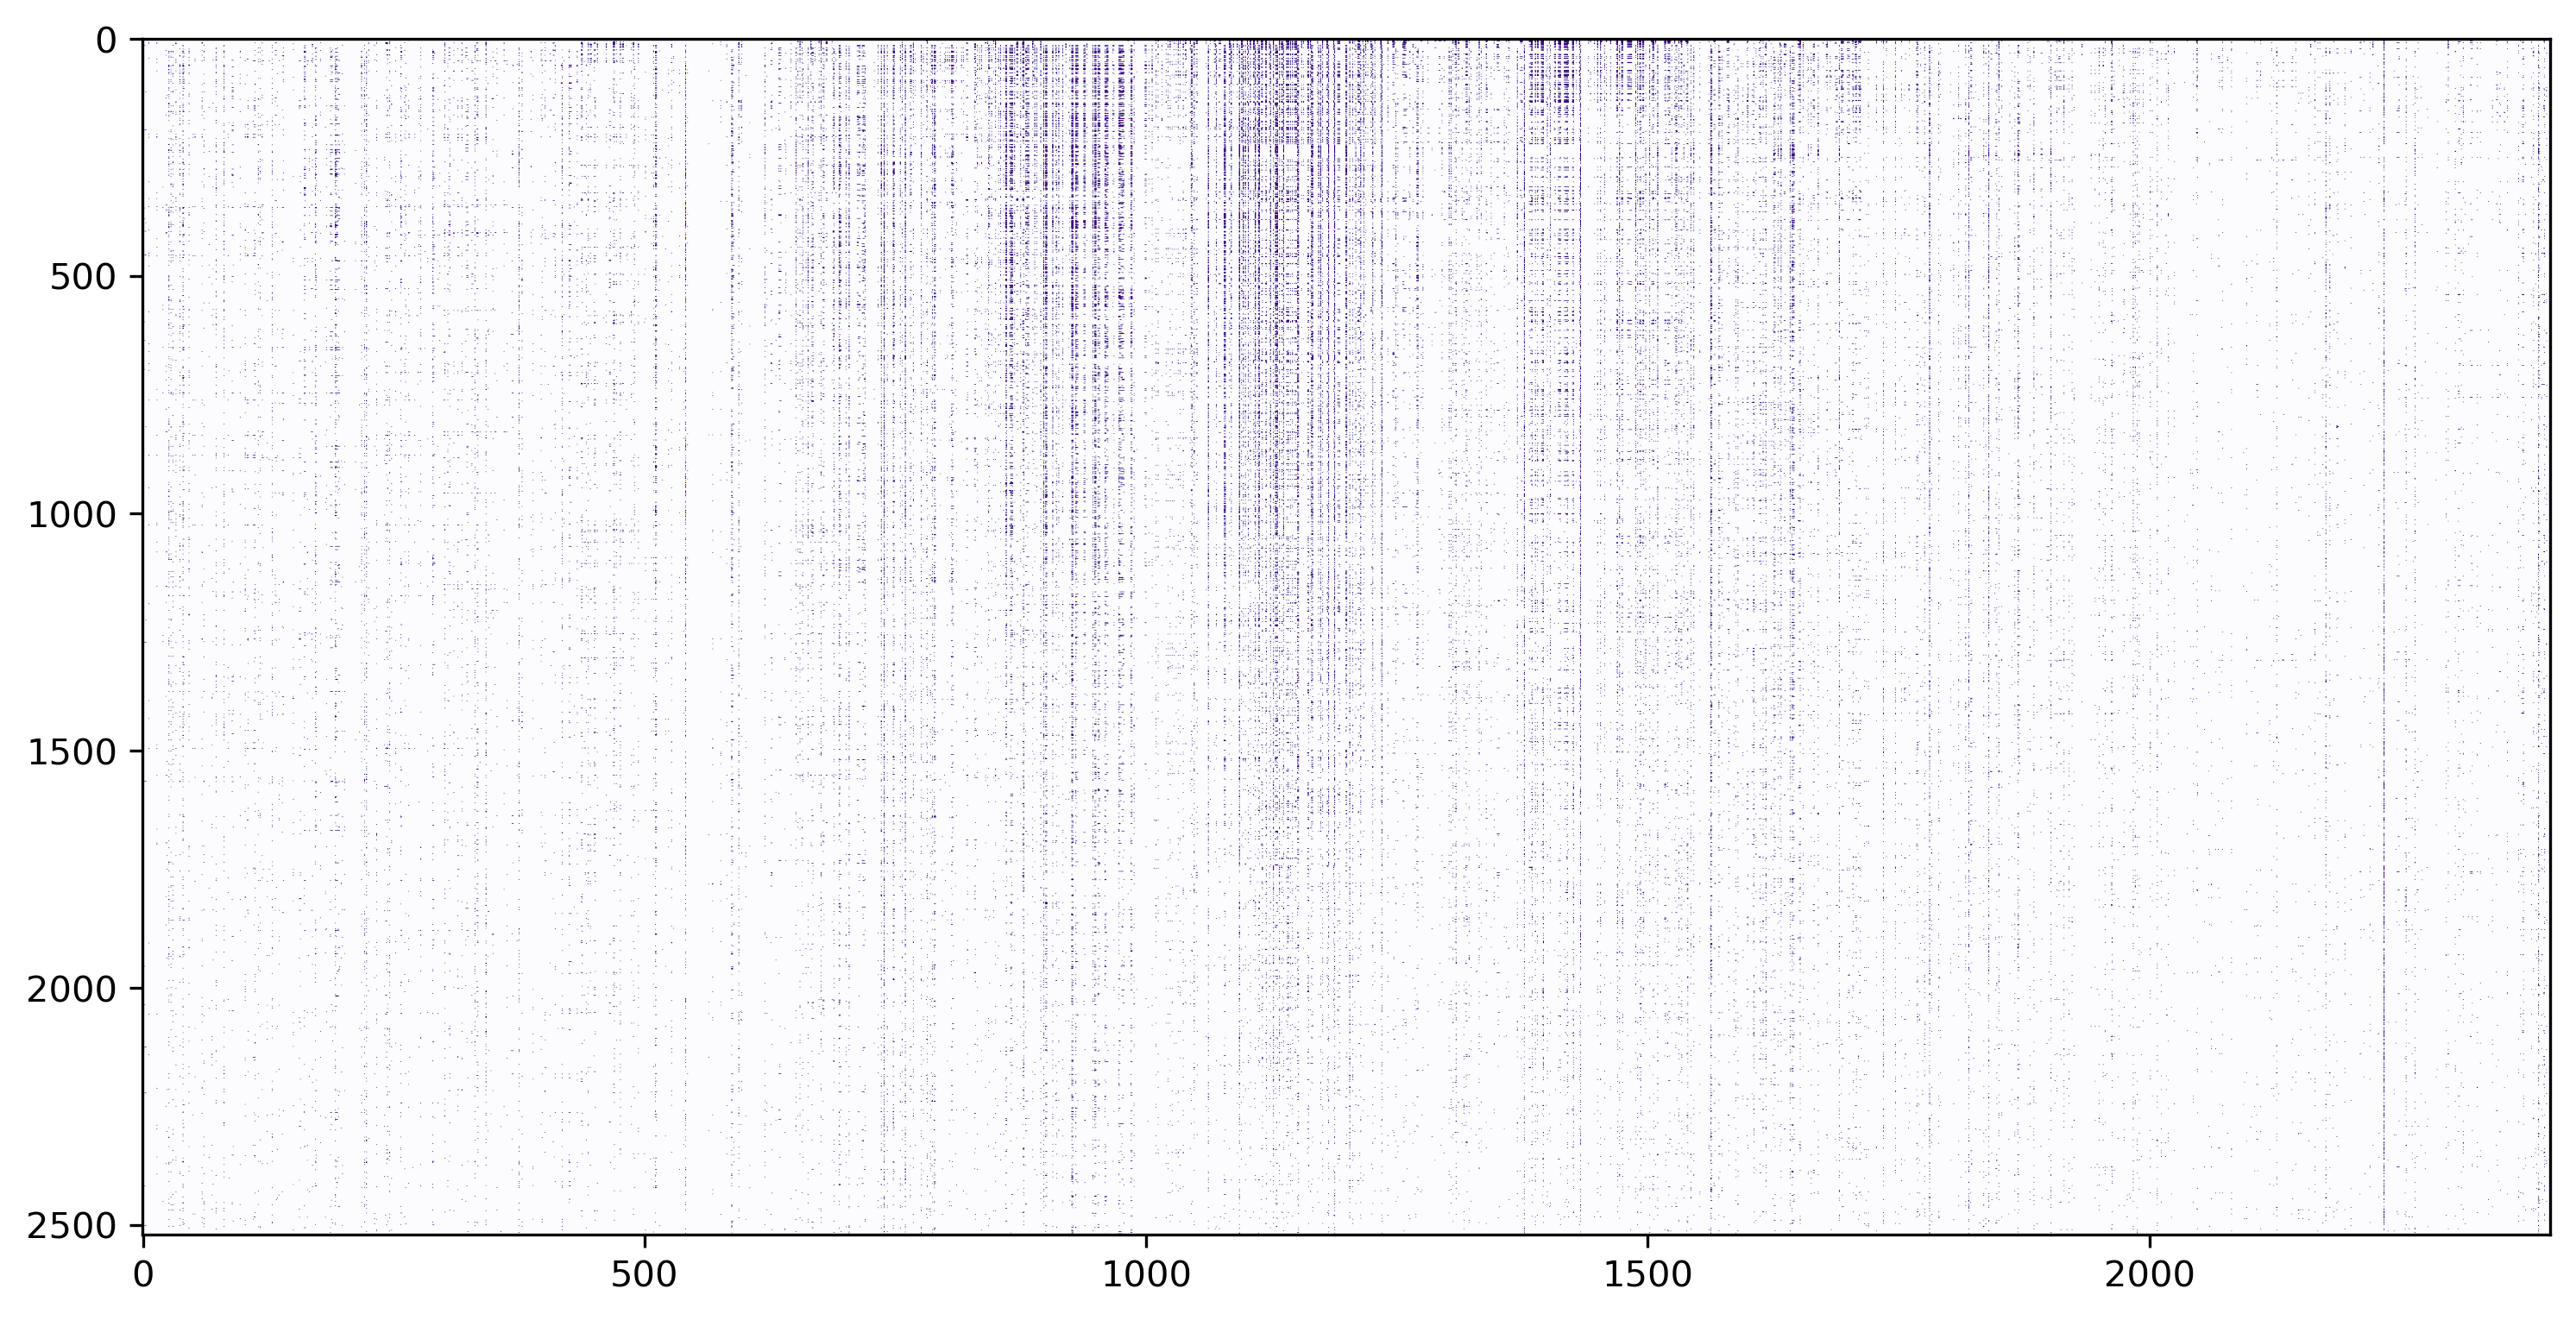

In [24]:
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

# Plot edits of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num)]
ax.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap="Purples")

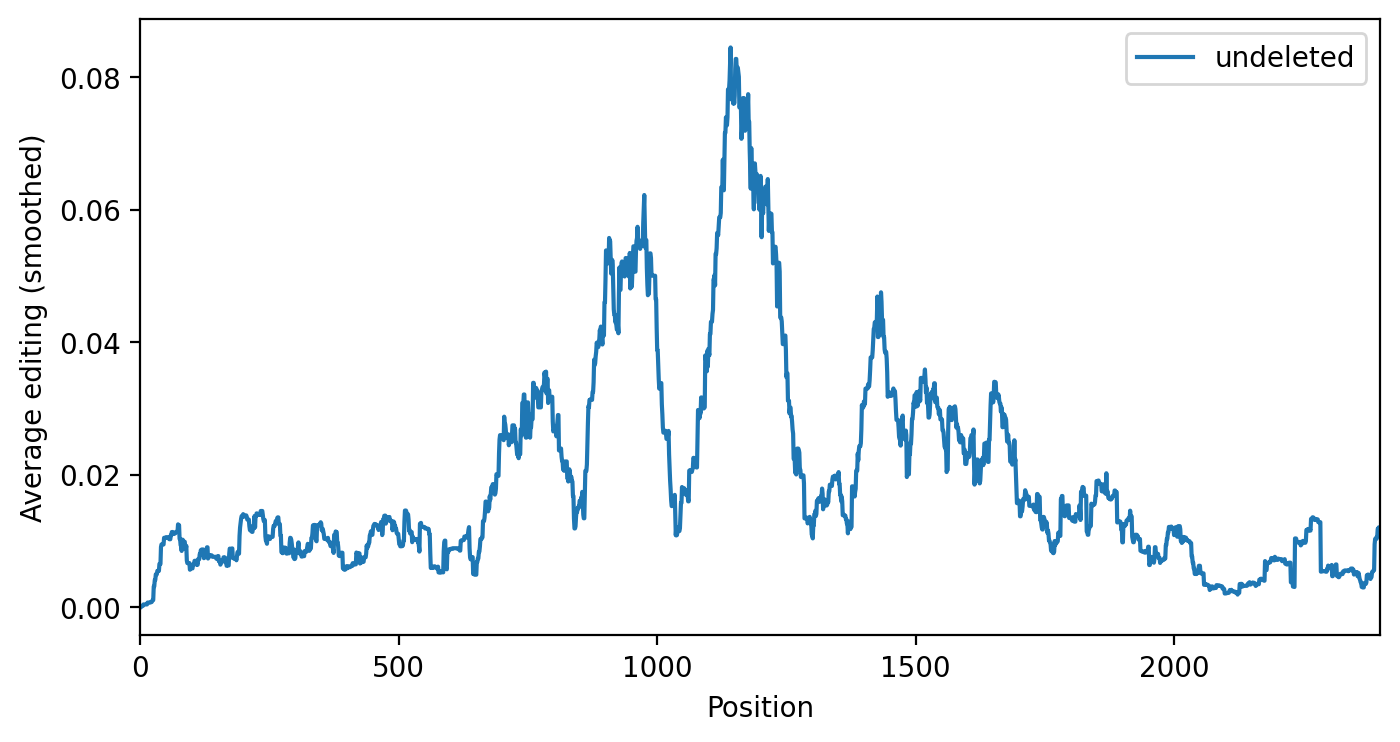

In [25]:
# Calculate average editing rate for each condition
track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_undeleted_ac = np.convolve(track_undeleted_ac, np.ones(50))/50
track_undeleted_ac = track_undeleted_ac[plot_range]

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))

plt.plot(np.arange(len(track_undeleted_ac)), track_undeleted_ac, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.xlim(0, len(track_undeleted_ac) - 1)

plt.show()

In [31]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10/HJR250_10_MNase_x_values.pkl', 'rb') as f:
    MNase_x_values = pickle.load(f)
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10/HJR250_10_MNase_y_values.pkl', 'rb') as f:
    MNase_y_values = pickle.load(f)

with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10/HJR250_10_ATAC_x_values.pkl', 'rb') as f:
    ATAC_x_values = pickle.load(f)
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250_10/HJR250_10_ATAC_y_values.pkl', 'rb') as f:
    ATAC_y_values = pickle.load(f)

In [32]:
plot_range = np.arange(500, 2900)

In [33]:
MNase_x_values =MNase_x_values[plot_range]
MNase_y_values =MNase_y_values[plot_range]
ATAC_x_values= ATAC_x_values[plot_range]
ATAC_y_values =  ATAC_y_values[plot_range]

In [34]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])

/tmp/ipykernel_483733/2277010719.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout


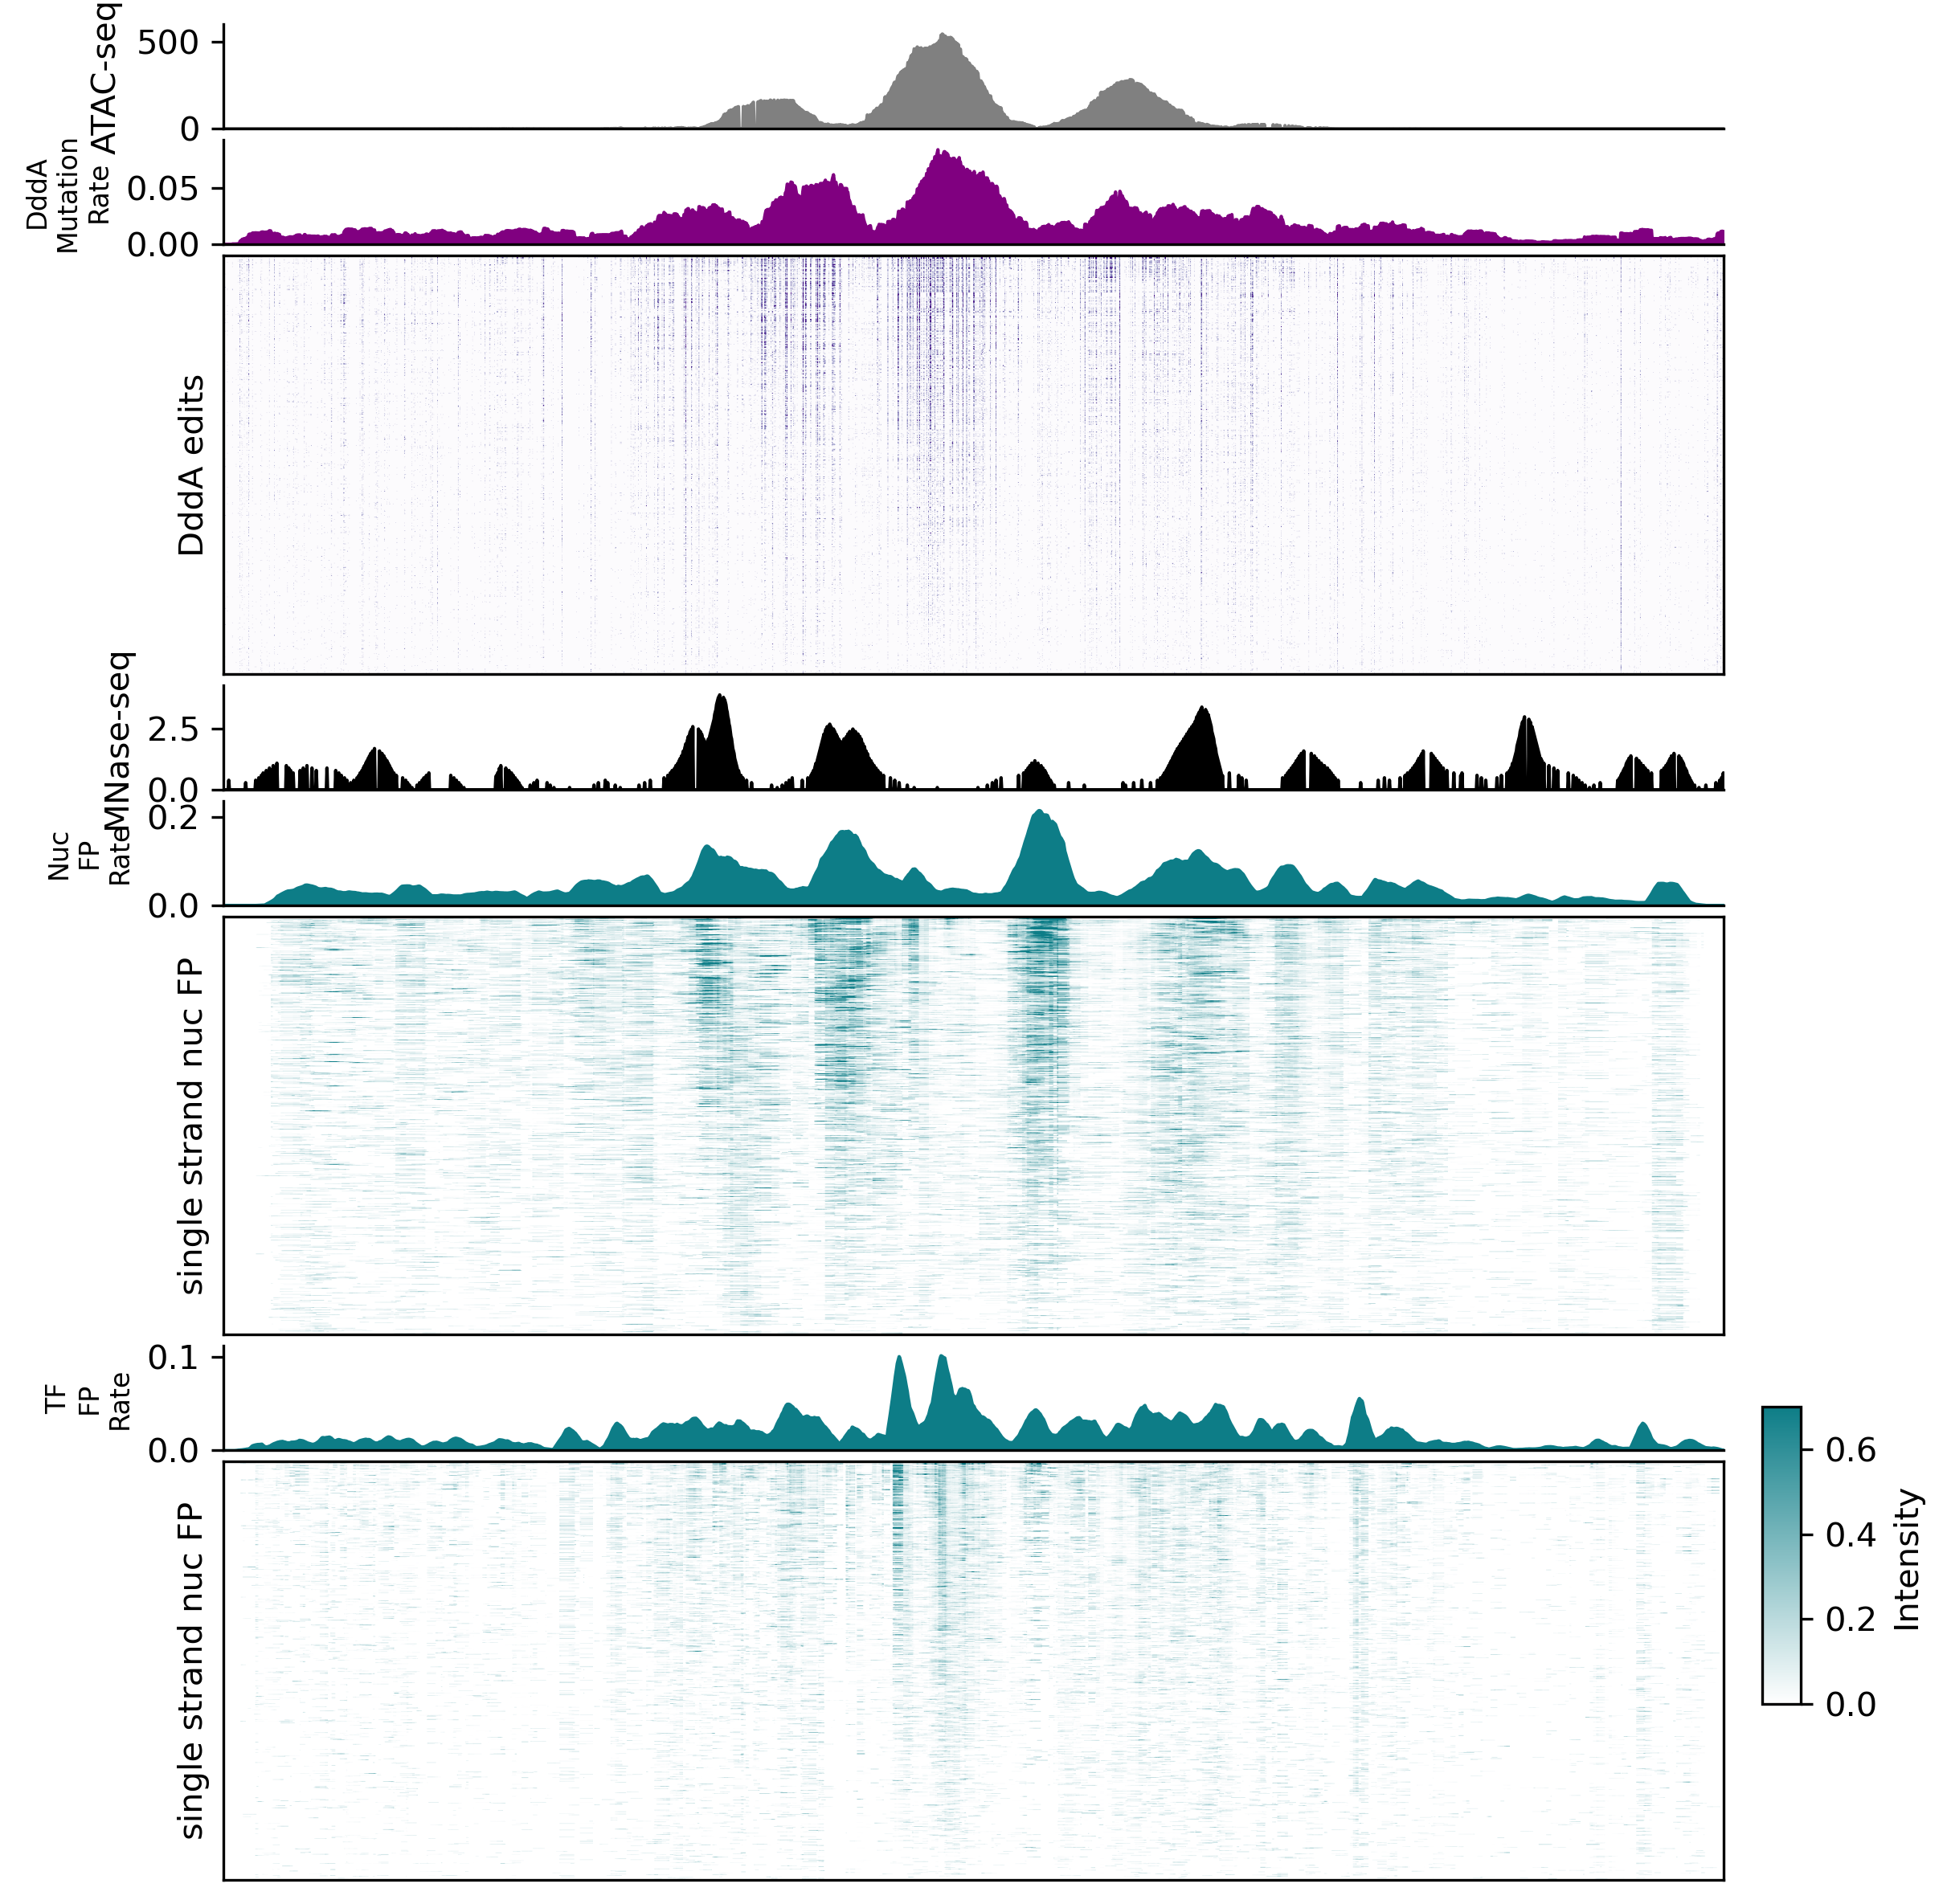

In [36]:
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as cbar
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(dpi=300,figsize=(8,8 ))  # Adjusted the figure size to accommodate four plots
gs = gridspec.GridSpec(8, 1, height_ratios=[0.5, 0.5, 2, 0.5, 0.5, 2, 0.5, 2])  # Adjusted to four rows

ax2 = plt.subplot(gs[0])
ax2.fill_between(ATAC_x_values, ATAC_y_values, color='Grey', alpha=1)
ax2.set_xlim([ATAC_x_values.min(), ATAC_x_values.max()])
ax2.set_ylim([0, max(ATAC_y_values) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('ATAC-seq')

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# First subplot (now second)
ax3 = plt.subplot(gs[1])
x_values = np.arange(len(track_undeleted_ac))
ax3.fill_between(x_values, track_undeleted_ac, color='purple', alpha=1)
ax3.set_xlim([x_values.min(), x_values.max()])
ax3.set_ylim([0, max(track_undeleted_ac) * 1.1])
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_xlabel('')
ax3.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

# Second subplot (now third)
ax4 = plt.subplot(gs[2])
ax4.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap='Purples')
ax4.set_ylabel('DddA edits')
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_yticks([])  # Remove y-axis ticks
ax4.set_xlabel('')

ax5 = plt.subplot(gs[3])
ax5.fill_between(MNase_x_values, MNase_y_values, color='Black', edgecolor='Black',alpha=1)
ax5.set_xlim([MNase_x_values.min(), MNase_x_values.max()])
ax5.set_ylim([0, max(MNase_y_values) * 1.1])
ax5.set_xticks([])  # Remove x-axis ticks
ax5.set_xlabel('')
ax5.set_ylabel('MNase-seq')

# Remove box outline and keep x and y axis
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

ax6 = plt.subplot(gs[4])
x_values = np.arange(len(track_undeleted_fp_nuc))
ax6.fill_between(x_values, track_undeleted_fp_nuc, color='#0d7d87', alpha=1)
ax6.set_xlim([x_values.min(), x_values.max()])
ax6.set_ylim([0, max(track_undeleted_fp_nuc) * 1.1])
ax6.set_xticks([])  # Remove x-axis ticks
ax6.set_xlabel('')
ax6.set_ylabel('Nuc\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

ax7 = plt.subplot(gs[5])
ax7.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=dark_green_cmap)
ax7.set_ylabel('single strand nuc FP')
ax7.set_xticks([])  # Remove x-axis ticks
ax7.set_yticks([])  # Remove y-axis ticks
ax7.set_xlabel('')

ax8 = plt.subplot(gs[6])
x_values = np.arange(len(track_undeleted_fp_TF))
ax8.fill_between(x_values, track_undeleted_fp_TF, color='#0d7d87', alpha=1)
ax8.set_xlim([x_values.min(), x_values.max()])
ax8.set_ylim([0, max(track_undeleted_fp_TF) * 1.1])
ax8.set_xticks([])  # Remove x-axis ticks
ax8.set_xlabel('')
ax8.set_ylabel('TF\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)

# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

ax9 = plt.subplot(gs[7])
ax9.imshow(fp_TF[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=dark_green_cmap)
ax9.tick_params(left=False, bottom=False)
ax9.set_ylabel('single strand nuc FP')
ax9.set_xticks([])  # Remove x-axis ticks
ax9.set_yticks([])  # Remove y-axis ticks
ax9.set_xlabel('')

im = ax9.imshow(fp_TF[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=dark_green_cmap)
ax9.tick_params(left=False, bottom=False)
ax9.set_ylabel('single strand nuc FP')
ax9.set_xticks([])  # Remove x-axis ticks
ax9.set_yticks([])  # Remove y-axis ticks
ax9.set_xlabel('')

# Add colorbar next to the right side of ax9 plot
cbar_ax = fig.add_axes([0.92, ax9.get_position().y0, 0.02, ax9.get_position().height])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Intensity')  # You can customize the label

plt.tight_layout()  # Adjust layout
plt.subplots_adjust(hspace=0.05, right=0.9)  # Adjust space between plots and leave room for colorbar


#plt.savefig(os.path.join(plot_dir, "HJR250_10_accessibility_FP.pdf"))
plt.show()